<a href="https://colab.research.google.com/github/sonnylau98/torch-fire/blob/main/transformer0429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import pandas as pd
import torch
from torch import nn

from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

import inspect
import tarfile
import zipfile
import os
import hashlib
import requests
import collections
from IPython import display

In [4]:
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB = dict()

In [5]:
#@title Functions

numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
expand_dims = lambda x, *args, **kwargs: x.unsqueeze(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

def cpu():
    """Get the CPU device.

    Defined in :numref:`sec_use_gpu`"""
    return torch.device('cpu')

def gpu(i=0):
    """Get a GPU device.

    Defined in :numref:`sec_use_gpu`"""
    return torch.device(f'cuda:{i}')

def num_gpus_fun():
    """Get the number of available GPUs.

    Defined in :numref:`sec_use_gpu`"""
    return torch.cuda.device_count()

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if num_gpus_fun() >= i + 1:
        return gpu(i)
    return cpu()

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU.

    Defined in :numref:`sec_seq2seq_training`"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [6]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [7]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization.

    Defined in :numref:`subsec_positionwise-ffn`"""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# Queries, Keys, and Values


So far all the networks we have reviewed crucially relied on the input being of a well-defned size. For instance, the images in ImageNet are of size $224\times224$ pixels and CNNs are specifically tuned to this size. Even in natural language processing the input size for RNNs is well defined and fixed. Variable size is addressed by sequentially processing one token at a time, or by specially designed convolution kernels.This approach can lead to significant problems when the input is truly of varying size with varyinglinformation content, such as in Section 10.7 in the transformation of text. In particular, for long sequences it becomes quite difficult to keep track of everything that has already been generated or even viewed by the network.
Compare this to databases. In their simplest form they are collections of keys $(k)$ and values $(v)$. For instance, our database $\mathcal{D}$ might consist of tuples {("Zhang","Aston"),("Lipton","Zachary"),("Li","Mu"),("Smola","Alex"),("Hu""Rachel"),("Werness","Brent")} with the last name being the key and the first name being the value. We can operate on $\mathcal{D}$, for instance with the exact query $(q)$ for "Li" which would return the
 value "Mu". If ("Li", "Mu") was not a record in $D$, there would be no valid answer. If we also allowed for approximate matches, we would retrieve ("Lipton",“Zachary") instead.

This quite simple and trivial example nonetheless teaches us a number of useful things:
* We can design queries $q$ that operate on $(k,v)$ pairs in such a manner as to be valid regardless of the database size.
* The same query can receive different answers, according to the contents of the database.
* The "code" being executed for operating on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-$k$).
* There is no need to compress or simplify the database to make the operations effective.




We will cover the specifics of the attention mechanis' application to machine translation later. For now, simply consider the following: denote by $\mathcal{D}\stackrel{\mathrm{def}}{=}\{(\mathbf{k}_{1},\mathbf{v}_{1}),\ldots(\mathbf{k}_{m},\mathbf{v}_{m})\}$ a database of $m$ tuples of keys and values. Moreover, denote by $\mathbf{q}$ a query. Then we can define the attention over $\mathcal{D}$ as

$$\text{Attention}(\mathbf{q},\mathcal{D})\stackrel{\text{def}}{=}\sum_{i=1}^m\alpha(\mathbf{q},\mathbf{k}_i)\mathbf{v}_i,$$

where $\alpha(\mathbf{q},\mathbf{k}_i)\in\mathbb{R}\left(i=1,\ldots,m\right)$ are scalar attention weights. The operation itself is typically referred to as attention pooling. The name $attention$ derives from the fact that the operation pays particular attention to the terms for which the weight $\alpha$ is significant (i.e., large). As such, the attention over $\mathcal{D}$ generates a linear combination of values contained in the database. In fact, this contains the above example as a special case where all but one weight is zero. We have a number of special cases:

* The weights $\alpha(\mathbf{q},\mathbf{k}_i)$ are nonnegative. In this case the output of the attention mechanism is contained in the convex cone spanned by the values $\mathbf{v}_i.$
* The weights $\alpha(\mathbf{q},\mathbf{k}_i)$ form a convex combination, i.e, $\sum_i\alpha(\mathbf{q},\mathbf{k}_i)=1$ and $\alpha(\mathbf{q},\mathbf{k}_i)\geq0$ for all $i$. This is the most common setting in deep learning.
* Exactly one of the weights $\alpha(\mathbf{q},\mathbf{k}_i)$ is $1$, while all others are $0$. This is akin to a traditional database query.
* All weights are equal, i.e., $\alpha(\mathbf{q},\mathbf{k}_i)=\frac1m$ for all $i$. This amounts to averaging across the entire database, also called average pooling in deep learning.

A common strategy for ensuring that the weights sum up to $1$ is to normalize them via

$$\alpha(\mathbf{q},\mathbf{k}_i)=\frac{\alpha(\mathbf{q},\mathbf{k}_i)}{\sum_j\alpha(\mathbf{q},\mathbf{k}_j)}.$$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick anyfunction $\alpha(\mathbf{q},\mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$\alpha(\mathbf{q},\mathbf{k}_i)=\frac{\exp(\alpha(\mathbf{q},\mathbf{k}_i))}{\sum_j\exp(\alpha(\mathbf{q},\mathbf{k}_j))}.$$

This operation is readily available in all deep learning frameworks. It is differentiable and its gradient never vanishes, all of which are desirable properties in a model. Note though, the attention mechanism introduced above is not the only option. For instance, we can design a non-differentiable attention model that can be trained using reinforcement learning methods. As one would expect, training such a model is quite complex. Consequently the bulk of modern attention research follows the framework outlined in Fig. We thus focus our exposition on this family of differentiable mechanisms.

![qkv](https://d2l.ai/_images/qkv.svg)

# Attention Pooling by Similarity

Now that we have introduced the primary components of the attention mechanism, let's use them in a rather classical setting, namely regression and classification via kernel density estimation. This detour simply provides additional background: it is entirely optional and can be skipped if needed. At their core, Nadaraya- Watson estimators rely on some similarity kernel $\alpha(\mathbf{q},\mathbf{k})$ relating queries $\mathbf{q}$ to keys $\mathbf{k}$. Some common kernels are

$$\begin{aligned}
&\alpha(\mathbf{q,k}) =\exp\left(-\frac12\|\mathbf{q}-\mathbf{k}\|^2\right) && \text{Gaussian;}  \\
&\alpha(\mathbf{q,k}) =1\mathrm{~if~}\|\mathbf{q}-\mathbf{k}\|\leq1 && \mathrm{Boxcar};  \\
&\alpha(\mathbf{q,k}) =\max\left(0,1-\|\mathbf{q}-\mathbf{k}\|\right) && \text{Epanechikov.}
\end{aligned}$$

There are many more choices that we could pick. See a Wikipedia article for a more extensive review and how the choice of kernels is related to kernel density estimation, sometimes also called Parzen Windows (Parzen,1957). All of the kernels are heuristic and can be tuned. For instance, we can adjust the width, not only on a global basis but even on a per-coordinate basis. Regardless, all of them lead to the following equation for regression and classification alike:

$$f(\mathbf{q})=\sum_i\mathbf{v}_i\frac{\alpha(\mathbf{q},\mathbf{k}_i)}{\sum_j\alpha(\mathbf{q},\mathbf{k}_j)}.$$

In the case of a (scalar) regression with observations $(\mathbf{x}_i,y_i)$ for features and labels respectively, $\mathbf{v}_i=y_i$ are scalars, $\mathbf{k}_i=\mathbf{x}_i$ are vectors, and the query $\mathbf{q}$ denotes the new location where $f$ should be evaluated. In the case of (muticlass) classification, we use one-hot-encoding of $y_i$ to obtain $\mathbf{v}_i$. One of the convenient properties of this estimator is that it requires no training. Even more so, if we suitably narrow the kernel with increasing amounts of data, the approach is consistent, i.e., it will converge to some statistically optimal solution. Let's start by inspecting some kernels.

# Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that
$$
\mathbf{Q}=[\mathbf{Q}_1,\mathbf{Q}_2,\ldots,\mathbf{Q}_n]\in\mathbb{R}^{n\times a\times b},\\\mathbf{K}=[\mathbf{K}_1,\mathbf{K}_2,\ldots,\mathbf{K}_n]\in\mathbb{R}^{n\times b\times c}.
$$
(11.3.4)
Then the batch matrix multiplication (BMM) computes the elementwise product

$$
\mathrm{BMM}(\mathbf{Q},\mathbf{K})=[\mathbf{Q}_1\mathbf{K}_1,\mathbf{Q}_2\mathbf{K}_2,\ldots,\mathbf{Q}_n\mathbf{K}_n]\in\mathbb{R}^{n\times a\times c}.
$$
 (11.3.5)
Let's see this in action in a deep learning framework.

# Attention Scoring Functions

![attention-output.](https://d2l.ai/_images/attention-output.svg)

## Dot Product Attention

Let's review the attention function (without exponentiation) from the Gaussian kernel for a moment:

$$
a(\mathbf{q},\mathbf{k}_i)=-\frac12\|\mathbf{q}-\mathbf{k}_i\|^2=\mathbf{q}^\top\mathbf{k}_i-\frac12\|\mathbf{k}_i\|^2-\frac12\|\mathbf{q}\|^2.
$$

First, note that the final term depends on $\mathbf{q}$ only. As such it is identical for all $(\mathbf{q},\mathbf{k}_i)$ pairs. Normalizing the attention weights to $1$, as is done in previous section, ensures that this term disappears entirely. Second, note that both batch and layer normalization(to be discussed later) lead to activations that have well-bounded, and often constant, norms $\|\mathbf{k}_i\|$. This is the case, for instance, whenever the keys $\mathbf{k}_i$ were generated by a layer norm. As such, we can drop it from the definition of $a$ without any major change in the outcome.

Last, we need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q}\in\mathbb{R}^d$ and the key $\mathbf{k}_i\in\mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains $1$ regardless of vector length, we use the scaled dot product attention scoring function. Thatis,we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used, e.g., in Transformers:

$$
a(\mathbf{q},\mathbf{k}_i)=\mathbf{q}^\top\mathbf{k}_i/\sqrt{d}.
$$

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via below equation by using the softmax operation:

$$
\alpha(\mathbf{q},\mathbf{k}_i)=\mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i))=\frac{\exp(\mathbf{q}^\top\mathbf{k}_i/\sqrt{d})}{\sum_{j=1}\exp(\mathbf{q}^\top\mathbf{k}_j/\sqrt{d})}.
$$

As it turns out, all popular attention mechanisms use the softmax, hence we will limit ourselves to that in the remainder of this chapter.

In [9]:
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)


Before providing the implementation of multi-head attention, let's formalize this model mathematically. Given a query $\mathbf{q}\in\mathbb{R}^{d_q}$, a key $\mathbf{k}\in\mathbb{R}^{d_k}$, and a value $\mathbf{v}\in\mathbb{R}^{d_v}$, each attention head $\mathbf{h}_i\left(i=1,\ldots,h\right)$ is computed as

$$
\mathbf{h}_i=f(\mathbf{W}_i^{(q)}\mathbf{q},\mathbf{W}_i^{(k)}\mathbf{k},\mathbf{W}_i^{(v)}\mathbf{v})\in\mathbb{R}^{p_v},
$$

where $\mathbf{W}_i^{(q)}\in\mathbb{R}^{p_q\times d_q},\mathbf{W}_i^{(k)}\in\mathbb{R}^{p_k\times d_k}$, and $\mathbf{W}_i^{(v)}\in\mathbb{R}^{p_0\times d_v}$ are learnable parameters and $f$ is attention pooling, such as additive attention and scaled dot product attention in previous section. The multi-head attention output is another linear transformation via learnable parameters
 $\mathbf{W}_o\in\mathbb{R}^{p_o\times hp_v}$ of the concatenation of $h$ heads:

$$
\mathbf{W}_o\begin{bmatrix}\mathbf{h}_1\\\vdots\\\mathbf{h}_h\end{bmatrix}\in\mathbb{R}^{p_o}.
$$

Based on this design, each head may attend to different parts of the input. More sophisticated functions than the simple weighted average can be expressed.



![multi-head-attention](https://d2l.ai/_images/multi-head-attention.svg)

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_hiddens,
               num_heads, dropout, bias=False, **kwargs):
    super().__init__()
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

  def transpose_qkv(self, X):
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

  def transpose_output(self, X):
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

  def forward(self, queries, keys, values, valid_lens):
    queries = self.transpose_qkv(self.W_q(queries))
    keys = self.transpose_qkv(self.W_k(keys))
    values = self.transpose_qkv(self.W_v(values))

    if valid_lens is not None:
        valid_lens = torch.repeat_interleave(
            valid_lens, repeats=self.num_heads, dim=0)

    output = self.attention(queries, keys, values, valid_lens)
    output_concat = self.transpose_output(output)
    return self.W_o(output_concat)

In [11]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# Self-Attention and Positional Encoding

![cnn-rnn-self-attention](https://d2l.ai/_images/cnn-rnn-self-attention.svg)

Unlike RNNs, which recurrently process tokens of a sequence one-by-one, self-attention ditches sequential operations in favor of parallel computation. Note that self-attention by itself does not preserve the order of the sequence. What do we do if it really matters that the model
 knows in which order the input sequence arrived?
 Fhe dominant approach for preserving information about the order of tokens is to represent this to the model as an additional input associated
 with each token. These inputs are called positional encodings, and they can either be learned or fixed *a priori*. We now describe a simple scheme for fixed positional encodings based on sine and cosine functions.

Suppose that the input representation $\mathbf{X}\in\mathbb{R}^{n\times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. The positional encoding outputs $\mathbf{X}+\mathbf{P}$ using a positional embedding matrix $\mathbf{P}\in\mathbb{R}^{n\times d}$ of the same shape, whose element on the $i^\mathrm{th}$ row and the $(2j)^\mathrm{th}$ or the $(2j+1)^\mathrm{th}$
 column is

$$
p_{i,2j} =\sin\left(\frac{i}{10000^{2j/d}}\right),
$$

$$
p_{i,2j+1} =\cos\left(\frac{i}{10000^{2j/d}}\right).
$$

At first glance, this trigonometric function design looks weird. Before we give explanations of this design, let's first implement it in the following PositionalEncoding class.


In [12]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

# The Transformer Architecture

![transformer](http://d2l.ai/_images/transformer.svg)

In [13]:
class TransformerEncoder(nn.Module):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X


In [14]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [15]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [16]:
class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.

        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [17]:
class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
class Module(nn.Module, HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, numpy(to(value, cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [19]:
class Classifier(Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.

        Defined in :numref:`sec_classification`"""
        Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = astype(argmax(Y_hat, axis=1), Y.dtype)
        compare = astype(preds == reshape(Y, -1), torch.float32)
        return reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = reshape(Y, (-1,))
        return torch.nn.functional.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [20]:
class EncoderDecoder(Classifier):
    """The base class for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

In [21]:
class Seq2Seq(EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [22]:
def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath.

    Defined in :numref:`sec_utils`"""
    if not url.startswith('http'):
        # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def extract(filename, folder=None):
    """Extract a zip/tar file into folder.

    Defined in :numref:`sec_utils`"""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

In [23]:
class DataModule(HyperParameters):
    """The base class of data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

In [24]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [25]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [26]:
class MTFraEng(DataModule):
    """The English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    def _download(self):
        extract(download(
            DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        """Defined in :numref:`sec_machine_translation`"""
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """Defined in :numref:`sec_machine_translation`"""
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        """Defined in :numref:`sec_machine_translation`"""
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = reduce_sum(
                astype(array != vocab['<pad>'], torch.int32), 1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)

    def get_dataloader(self, train):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        """Defined in :numref:`subsec_loading-seq-fixed-len`"""
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs.

    Defined in :numref:`sec_machine_translation`"""
    set_figsize()
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

In [27]:
class Trainer(HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        self.gpus = [gpu(i) for i in range(min(num_gpus, num_gpus_fun()))]


    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [to(a, self.gpus[0]) for a in batch]
        return batch


    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

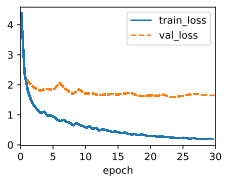

In [28]:
#@title Train

data = MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [29]:
#@title Test

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


# Large language model

A large language model (LLM) is a computational model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification. Based on language models, LLMs acquire these abilities by learning statistical relationships from text documents during a computationally intensive self-supervised and semi-supervised training process. LLMs can be used for text generation, a form of generative AI, by taking an input text and repeatedly predicting the next token or word.

# Generative pre-trained transformer (GPT)

Generative pre-trained transformers (GPT) are a type of large language model (LLM) and a prominent framework for generative artificial intelligence. They are artificial neural networks that are used in natural language processing tasks. GPTs are based on the transformer architecture, pre-trained on large data sets of unlabelled text, and able to generate novel human-like content.

![Full_GPT_architecture](https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Full_GPT_architecture.svg/800px-Full_GPT_architecture.svg.png)

## GeLU

$$g=0.5x\Bigg(1+\frac{2}{\sqrt{\pi}}\int_0^{\frac{x}{\sqrt{2}}}e^{-t^2}dt\Bigg)$$

![Activation_gelu](https://upload.wikimedia.org/wikipedia/commons/4/4e/Activation_gelu.png)